Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [5]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

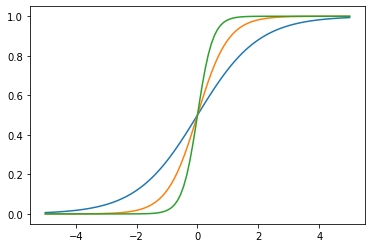

In [220]:
def sigm(x, l = 1):
    return 1 / (1 + exp(-x*l))

alfas = [1,2,4]
X = np.linspace(-5,5,100)
for a in alfas:
    plt.plot(X,list(map(lambda x: sigm(x,a),X)))

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [203]:
from numpy import linalg
import math
from sklearn.preprocessing import PolynomialFeatures

def lr_h(x,w):
    return sigm(w.T @ x)

def cross_entropy_error(X,y,w,negativ_class = False, alpha = 0):
    if negativ_class:
        E = (1/math.log(2)) * sum([math.log(1 + math.exp(-y * w.T @ x)) for x,y in zip(X,y)])
    else:
        E = sum([-(y * math.log(lr_h(x,w)) + (1 -y) * math.log(1 - lr_h(x,w))) for x,y in zip(X,y)])
    return 1 / len(X) * E

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    distinct_y = set(y)
    negativ_class = False
    # bi li valjalo da zamjenimo sve -1 s 0 
    assert len(distinct_y) == 2, "broj klasa mora biti točno 2"
    if -1 in distinct_y: negativ_class = True

    if trace: ws = []

    poly = PolynomialFeatures(1)
    th = poly.fit_transform(X)
    w = np.zeros(th.shape[1])
    last_entrpy = None
    for i in range(max_iter):
        delta_w = np.zeros(th.shape[1])

        for x,ys in zip(th,y):
            #ako je y = {-1,1} trebamo prilagoditi sigm funkciju?
            if negativ_class:
                delta_w = delta_w - ((2 * lr_h(x,w) - 1 - ys) * x)
            else:
                delta_w = delta_w - ((lr_h(x,w) - ys) * x)
        
        #L2 regularizacija
        w = np.array([x if i == 0 else x *(1 - alpha * eta) for i,x in enumerate(w)])  + eta * delta_w
        if trace: ws.append(w)
        if last_entrpy is not None and abs(last_entrpy - cross_entropy_error(th,y,w,negativ_class)) < epsilon:
            print("Izlazim jer je greška u entropijama manja od epsilon")
            break
        else: last_entrpy = cross_entropy_error(th,y,w,negativ_class)
    
    if trace: return ws
    return w


### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [215]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])


[ 4.68222856 -1.76885159  0.68429667]
Greška entropije 0.12669600388923927


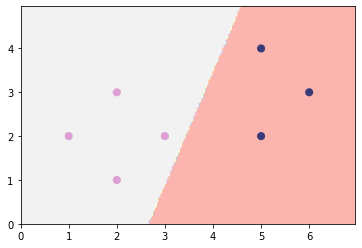

In [265]:
w = lr_train(seven_X,seven_y,max_iter=100,eta = 0.1)
print(w)
plot_2d_clf_problem(seven_X,seven_y,lambda x: lr_h(np.insert(x,0,1),w) >= 0.5)
poly = PolynomialFeatures(1)
th_seven = poly.fit_transform(seven_X)
print("Greška entropije",cross_entropy_error(th_seven,seven_y,w))

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

Izlazim jer je greška u entropijama manja od epsilon


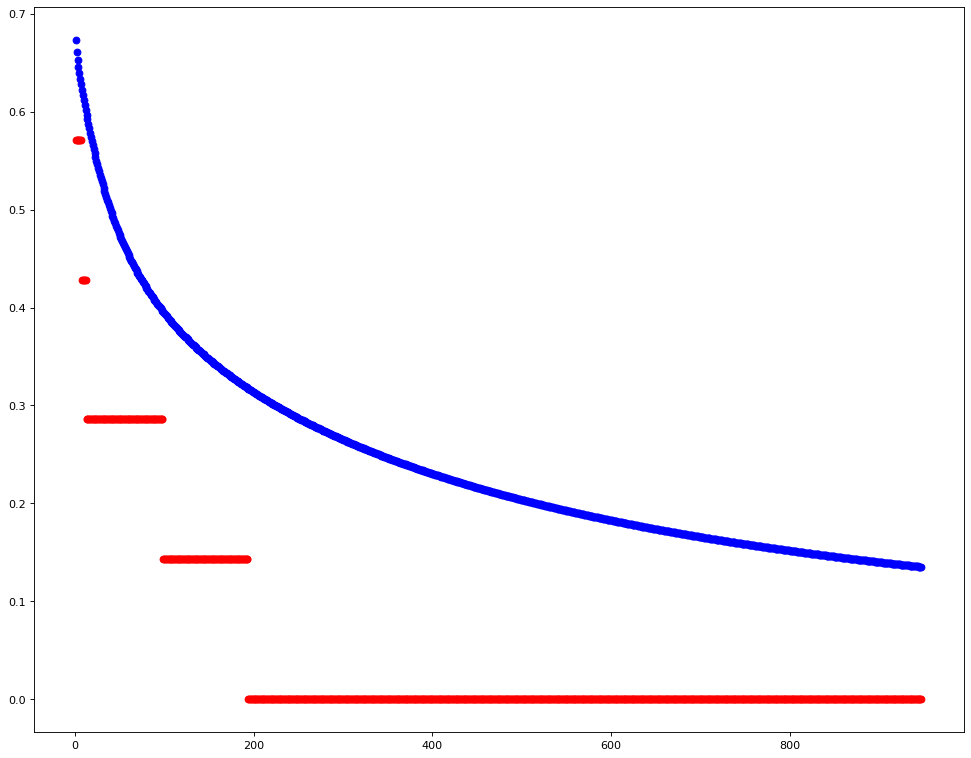

In [274]:
figure(figsize=(15, 12), dpi=80)
from sklearn.metrics import zero_one_loss
poly = PolynomialFeatures(1)
th_seven = poly.fit_transform(seven_X)
ws =  lr_train(seven_X,seven_y, trace = True)
for i,w in enumerate(ws):
    plt.scatter(i+1,cross_entropy_error(th_seven,seven_y,w), color = "b")
    plt.scatter(i+1,zero_one_loss(seven_y,np.array(list(map(lambda x: lr_h(np.insert(x,0,1),w) >= 0.5,seven_X)), int)), color = "r")

Izlazim jer je greška u entropijama manja od epsilon
Izlazim jer je greška u entropijama manja od epsilon
Izlazim jer je greška u entropijama manja od epsilon
Izlazim jer je greška u entropijama manja od epsilon


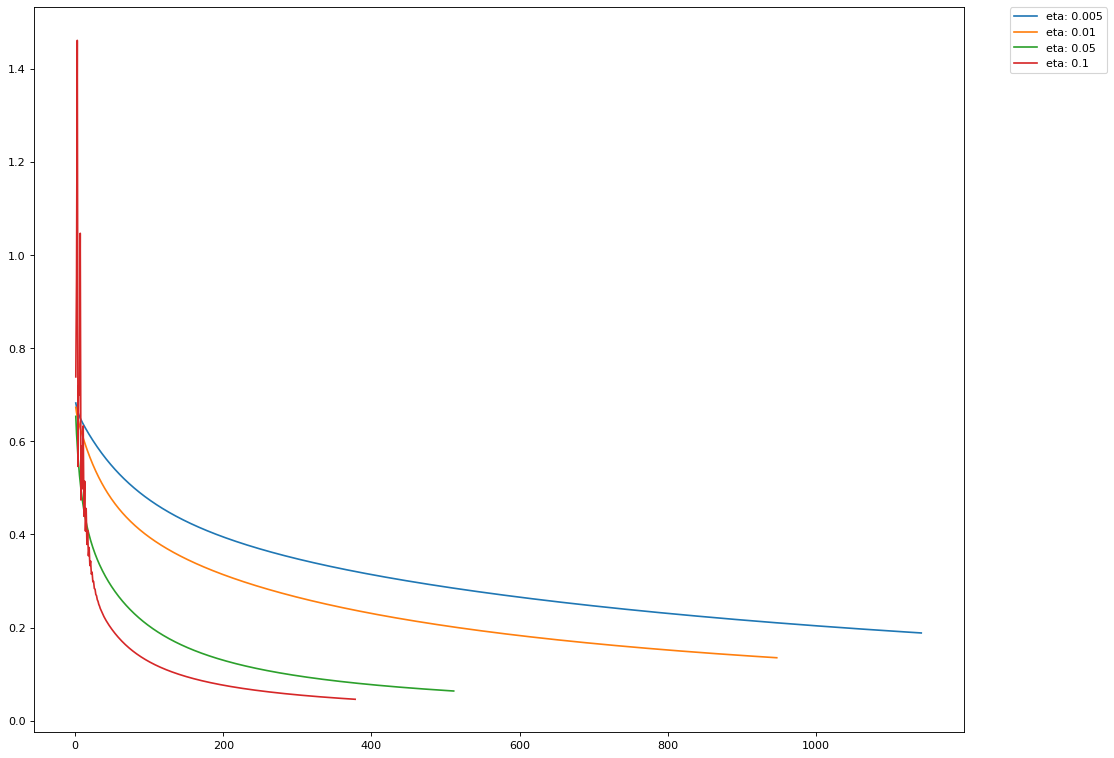

In [257]:
figure(figsize=(15, 12), dpi=80)
etas = [0.005,0.01,0.05,0.1]
wss =  [lr_train(seven_X,seven_y, trace = True,eta = e) for e in etas]
poly = PolynomialFeatures(1)
th_seven = poly.fit_transform(seven_X)
for k,ws in enumerate(wss):
    points = []
    for i,w in enumerate(ws):
        points.append([i+1,cross_entropy_error(th_seven,seven_y,w)])
    points = np.array(points)
    plt.plot(points[:,0],points[:,1], label = "eta: " + str(etas[k]))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#plt.axis([0, 100,0,1.4])


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

In [3]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0,penalty='none',max_iter=100).fit(seven_X, seven_y)
plot_2d_clf_problem(seven_X,seven_y,lambda x: clf.predict(x))


NameError: name 'seven_X' is not defined

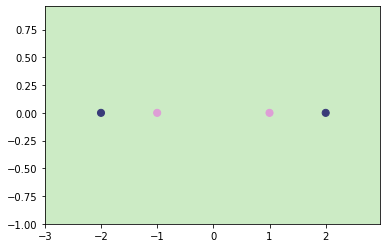

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
vjezba_X = np.array([[-2,0], [-1,0], [1,0], [2,0]])
vjezba_y = np.array([0,1,1,0])
poly = PolynomialFeatures(1)
th_vjezba = poly.fit_transform(vjezba_X)
clf = LogisticRegression(random_state=0,penalty='none').fit(vjezba_X, vjezba_y)
plot_2d_clf_problem(vjezba_X,vjezba_y,lambda x: clf.predict(x))


### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [253]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

Izlazim jer je greška u entropijama manja od epsilon
[ 4.23566419 -1.66592903  0.6994037 ]
Greška entropije 0.12597001345759548


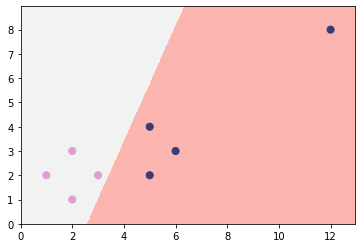

In [254]:
w = lr_train(outlier_X,outlier_y)
print(w)
plot_2d_clf_problem(outlier_X,outlier_y,lambda x: lr_h(np.insert(x,0,1),w) >= 0.5)
poly = PolynomialFeatures(1)
th_outlier = poly.fit_transform(outlier_X)
print("Greška entropije",cross_entropy_error(th_outlier,outlier_y,w))

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

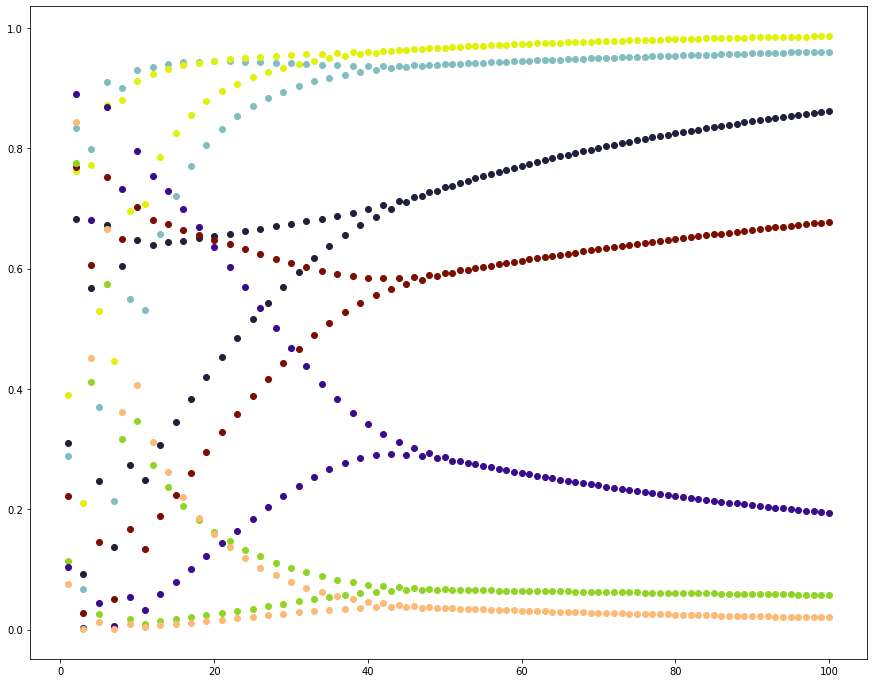

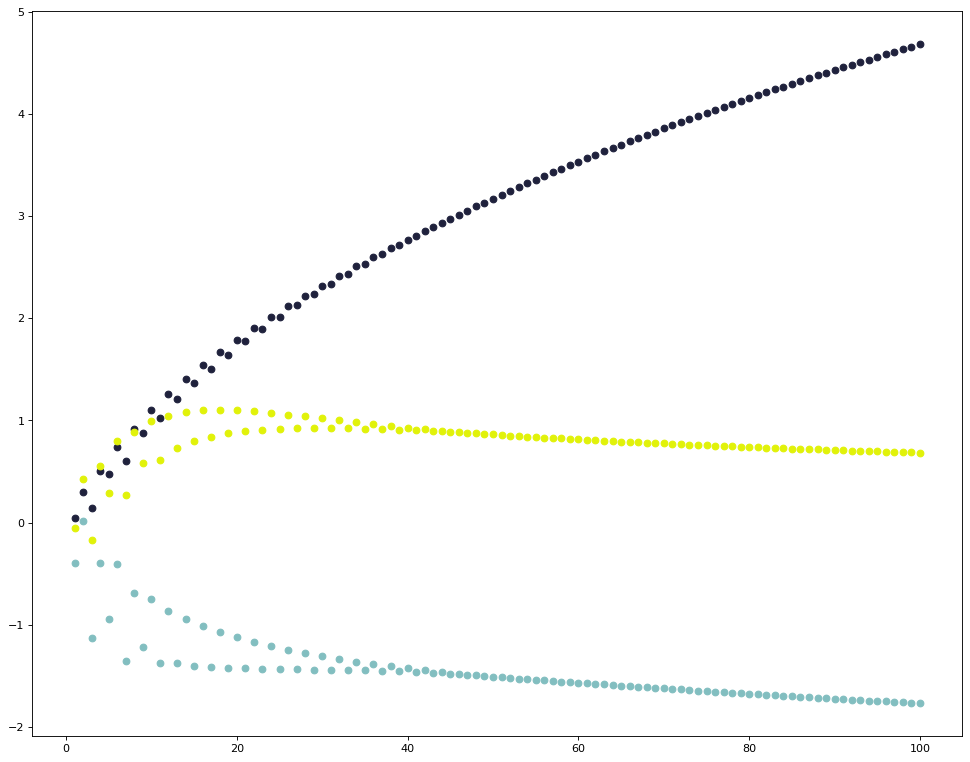

In [272]:
ws =  lr_train(seven_X,seven_y,max_iter=100,eta = 0.1,trace=True)
poly = PolynomialFeatures(1)
th_seven = poly.fit_transform(seven_X)
colors = []

for i in range(len(th_seven)):
    colors.append('#%06X' % randint(0, 0xFFFFFF))
for i,w in enumerate(ws):
    plt.figure(0,figsize=(15, 12))
    for j,x in enumerate(th_seven):
        plt.scatter(i+1,lr_h(x,w), color= colors[j])
    plt.figure(1,figsize=(15, 12))
    for j,wi in enumerate(w):
        plt.scatter(i+1,wi, color= colors[j])


### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [275]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

Izlazim jer je greška u entropijama manja od epsilon


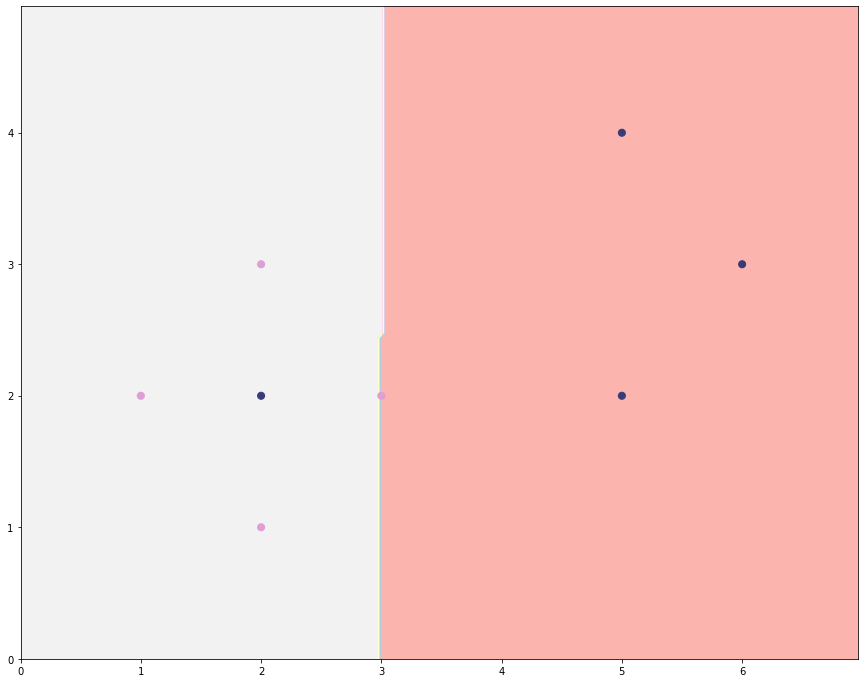

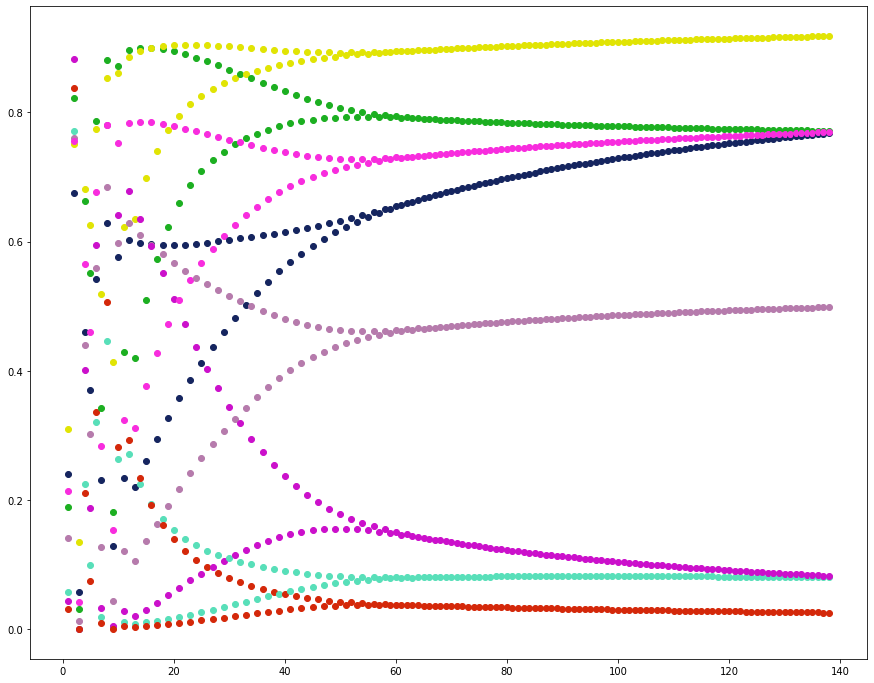

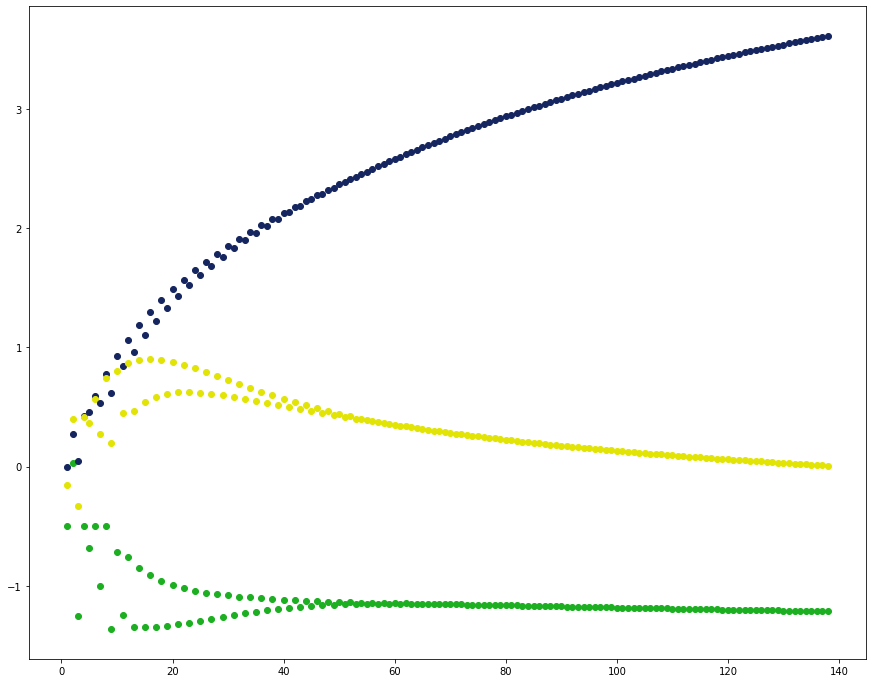

In [282]:
ws =  lr_train(unsep_X,unsep_y,max_iter=500,eta = 0.1,trace=True)
poly = PolynomialFeatures(1)
th_seven = poly.fit_transform(unsep_X)
plt.figure(0,figsize=(15, 12))
plot_2d_clf_problem(unsep_X,unsep_y,lambda x: lr_h(np.insert(x,0,1),ws[-1]) >= 0.5)
colors = []

for i in range(len(th_seven)):
    colors.append('#%06X' % randint(0, 0xFFFFFF))
for i,w in enumerate(ws):
    plt.figure(1,figsize=(15, 12))
    for j,x in enumerate(th_seven):
        plt.scatter(i+1,lr_h(x,w), color= colors[j])
    plt.figure(2,figsize=(15, 12))
    for j,wi in enumerate(w):
        plt.scatter(i+1,wi, color= colors[j])

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [ ]:
from numpy.linalg import norm

Izlazim jer je greška u entropijama manja od epsilon
Izlazim jer je greška u entropijama manja od epsilon
Izlazim jer je greška u entropijama manja od epsilon
Izlazim jer je greška u entropijama manja od epsilon


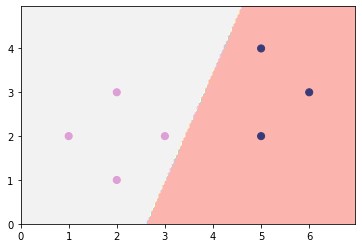

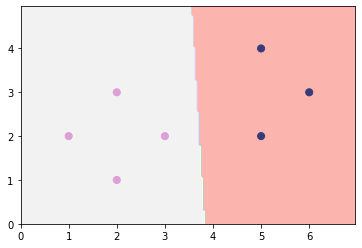

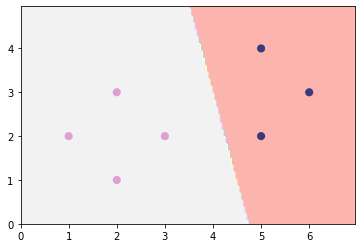

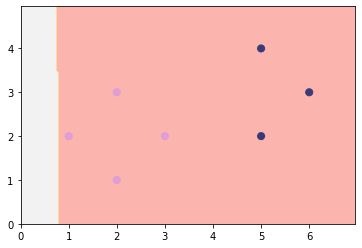

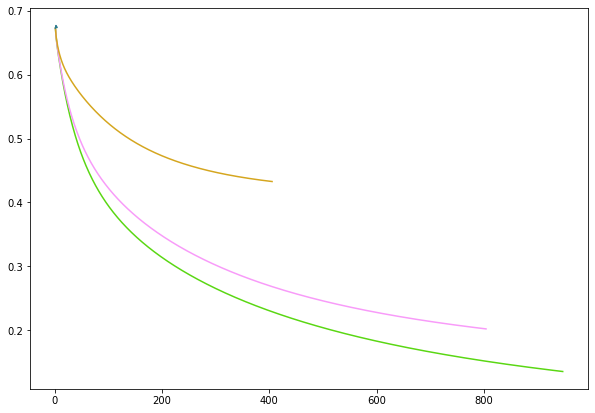

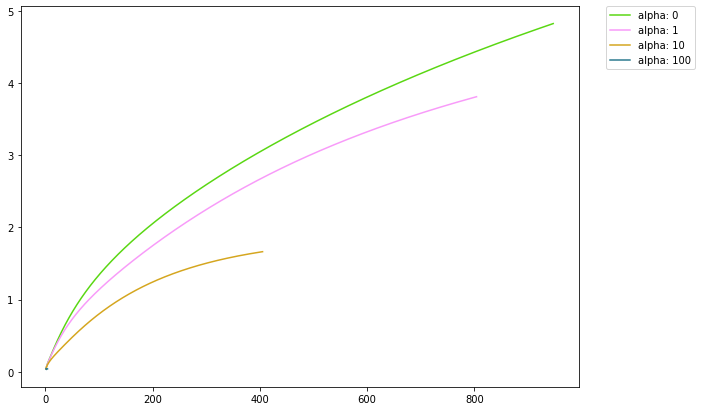

In [299]:
alphas = [0,1,10,100]
poly = PolynomialFeatures(1)
th_seven = poly.fit_transform(seven_X)
colors = []

for i in range(len(th_seven)):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

for j,a in enumerate(alphas):
    ws =  lr_train(seven_X,seven_y,alpha=a,trace=True)
    plt.figure(3*j)
    plot_2d_clf_problem(seven_X,seven_y,lambda x: lr_h(np.insert(x,0,1),ws[-1]) >= 0.5)
    points = []
    for i,w in enumerate(ws):
        points.append([i+1,cross_entropy_error(th_seven,seven_y,w),math.sqrt(w.T @ w)])
    points = np.array(points)
    plt.figure(1,figsize=(10, 7))
    plt.plot(points[:,0],points[:,1], color = colors[j],label="alpha: " + str(a))
    plt.figure(2,figsize=(10, 7))
    plt.plot(points[:,0],points[:,2], color = colors[j],label="alpha: " + str(a))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

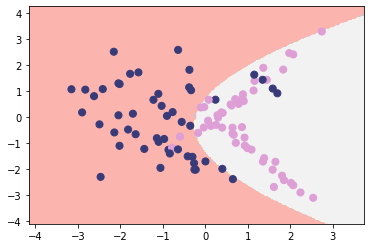

In [334]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification

X, y = make_classification(n_classes=2, n_redundant=0, n_clusters_per_class=2, n_features=2)
poly = PolynomialFeatures(2)
x2 = poly.fit_transform(X)
clf = LogisticRegression(random_state=0,penalty='none',max_iter=100).fit(x2, y)
plot_2d_clf_problem(X, y, lambda x : clf.predict(poly.transform(x)))


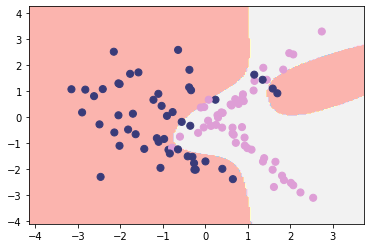

In [335]:

poly = PolynomialFeatures(3)
x3 = poly.fit_transform(X)
clf = LogisticRegression(random_state=0,penalty='none',max_iter=100).fit(x3, y)
plot_2d_clf_problem(X, y, lambda x : clf.predict(poly.transform(x)))

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?